In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
BASE_PATH = '/content/gdrive/My Drive/Learning/lung segmentation/data'
os.chdir(BASE_PATH)
!ls

Mounted at /content/gdrive
batches_predict  data  Infection_model	Infection_only	model  model_save


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))

  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))


Sun May 23 02:45:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import keras
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pickle
import cv2
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import cv2
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler,CSVLogger
from keras.models import load_model

In [ ]:

datapath_ct = os.path.join(BASE_PATH, '/COVID-19-CT-Seg_20cases')
# datapath_pkl = os.path.join(BASE_PATH, 'data/patches')
datapath_batch = os.path.join(BASE_PATH, 'data/batches32/')
model_saves = os.path.join(BASE_PATH, 'model_save/')

## Load all images and seg into dataframe

In [ ]:
all_images = glob.glob("{0}/*/batch_img_*.npz".format(datapath_batch))
all_masks = glob.glob("{0}/*/batch_seg_*.npz".format(datapath_batch))
print(all_images[0])

/content/gdrive/My Drive/Learning/lung segmentation/data/data/batches32/1/batch_img_1.npz


In [ ]:
df_all = pd.DataFrame.from_dict({ 'image': all_images, 'mask': all_masks })
df_all.head()

,image,mask
0,/content/gdrive/My Drive/Learning/lung segment...,/content/gdrive/My Drive/Learning/lung segment...
1,/content/gdrive/My Drive/Learning/lung segment...,/content/gdrive/My Drive/Learning/lung segment...
2,/content/gdrive/My Drive/Learning/lung segment...,/content/gdrive/My Drive/Learning/lung segment...
3,/content/gdrive/My Drive/Learning/lung segment...,/content/gdrive/My Drive/Learning/lung segment...
4,/content/gdrive/My Drive/Learning/lung segment...,/content/gdrive/My Drive/Learning/lung segment...


In [ ]:
df_all.shape

(568, 2)

## Create Data Generator for K folds

In [ ]:
class DataGeneratorKFold(keras.utils.Sequence):
  def __init__(self, image_paths, mask_paths, batch_size=None):
    self.image_paths = image_paths
    self.mask_paths = mask_paths
    self.batch_size = batch_size
    self.indices = np.arange(len(self.image_paths))
    np.random.shuffle(self.indices)

  def __getitem__(self, idx):
    real_index = self.indices[idx]
    # CLASS_A_CHANNEL = 0
    # CLASS_B_CHANNEL = 1
    # CLASS_C_CHANNEL = 2
    # CLASS_D_CHANNEL = 3
    # CLASS_A_WEIGHT = 1
    # CLASS_B_WEIGHT = 1
    # CLASS_C_WEIGHT = 1
    # CLASS_D_WEIGHT = 2
    # print("Loading item at index: {0}....".format(real_index))
    image_data = np.load(self.image_paths[real_index])["data"]
    mask_data = np.load(self.mask_paths[real_index])["data"]
    # for label in mask_data:     
    #   label[ label[:,:,:,CLASS_A_CHANNEL] == 1 ] *= CLASS_A_WEIGHT
    #   label[ label[:,:,:,CLASS_B_CHANNEL] == 1 ] *= CLASS_B_WEIGHT
    #   label[ label[:,:,:,CLASS_C_CHANNEL] == 1 ] *= CLASS_C_WEIGHT
    #   label[ label[:,:,:,CLASS_D_CHANNEL] == 1 ] *= CLASS_D_WEIGHT
    # augmented = MySequence(self.image_paths,self.mask_paths, real_index)
    return (image_data,mask_data)

 
  def __len__(self):
    return int(np.floor(len(self.image_paths) / self.batch_size))

  def on_epoch_end(self):
    np.random.shuffle(self.indices)
    return



In [ ]:
def getDataGeneratorsForFolds (dataframe, image_column, mask_column, num_folds, batch_size=4):
  result = []
  val_size = int(np.round(dataframe.shape[0] / num_folds))
  for k in range(num_folds):
    val_start = k * val_size
    val_end = val_start + val_size
    df_val = dataframe.iloc[val_start:val_end]
    val_images = df_val[image_column].tolist()
    val_masks = df_val[mask_column].tolist()
    generator_val = DataGeneratorKFold(val_images, val_masks, batch_size=4)

    df_train_head = dataframe.iloc[0:val_start]
    df_train_tail = dataframe.iloc[val_end:]
    train_images = df_train_head[image_column].tolist() + df_train_tail[image_column].tolist()
    train_masks = df_train_head[mask_column].tolist() + df_train_tail[mask_column].tolist()
    generator_train = DataGeneratorKFold(train_images, train_masks, batch_size=4)

    result.append((generator_train, generator_train))
  return result



df_all_shuffled = shuffle(df_all, random_state=42)
df_all_shuffled.reset_index(inplace=True, drop=True)
if 'shuffled_data.csv' in os.listdir(model_saves):
  data_generators_each_fold = getDataGeneratorsForFolds(pd.read_csv(model_saves+'shuffled_data.csv'), image_column='image', mask_column='mask', num_folds=5)
else:
  df_all_shuffled.to_csv(model_saves+'/shuffled_data.csv')
  data_generators_each_fold = getDataGeneratorsForFolds(df_all_shuffled, image_column='image', mask_column='mask', num_folds=5)

In [ ]:

from keras.layers import Input, concatenate, Conv3D, MaxPooling3D, Conv3DTranspose, AveragePooling3D, ZeroPadding3D, BatchNormalization
from keras.optimizers import RMSprop, Adam, SGD, Adagrad, Adadelta
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras import backend as K
from keras.utils import plot_model


K.set_image_data_format('channels_last')

project_name = '3D-Unet'
img_rows = 128
img_cols = 128
img_depth = 32



def get_unet():
    inputs = Input((img_rows, img_cols, img_depth, 1))
    conv11 = Conv3D(32, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(inputs)
    conv12 = Conv3D(32, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(conv11)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv12)

    conv21 = Conv3D(64, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(pool1)
    conv22 = Conv3D(64, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(conv21)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv22)

    conv31 = Conv3D(128, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(pool2)
    conv32 = Conv3D(128, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(conv31)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv32)

    conv41 = Conv3D(256, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(pool3)
    conv42 = Conv3D(256, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(conv41)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv42)

    conv51 = Conv3D(512, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(pool4)
    conv52 = Conv3D(512, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(conv51)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv52), conv42], axis=4)
    conv61 = Conv3D(256, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(up6)
    conv62 = Conv3D(256, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(conv61)


    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv62), conv32], axis=4)
    conv71 = Conv3D(128, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(up7)
    conv72 = Conv3D(128, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(conv71)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv72), conv22], axis=4)
    conv81 = Conv3D(64, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(up8)
    conv82 = Conv3D(64, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(conv81)


    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv82), conv12], axis=4)
    conv91 = Conv3D(32, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(up9)
    conv92 = Conv3D(32, (3, 3, 3), activation='elu',kernel_initializer='he_normal', padding='same')(conv91)

    conv10 = Conv3D(4, (1, 1, 1), activation= 'softmax')(conv92)

    model = Model(inputs=[inputs], outputs=[conv10])
    #plot_model(model, to_file='model.png')

   
    return model


In [ ]:
 
model = get_unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 32 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 32, 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 32, 27680       conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 64, 64, 16, 3 0           conv3d_1[0][0]                   
______________________________________________________________________________________________

## Define model

In [ ]:

from tensorflow.keras import backend as K
from keras.optimizers import Adam

def identify_axis(shape):
    # Three dimensional
    if len(shape) == 5 : return [1,2,3]
    # Two dimensional
    elif len(shape) == 4 : return [1,2]
    # Exception - Unknown
    else : raise ValueError('Metric: Shape of tensor is neither 2D or 3D.')

def dsc(y_true, y_pred, smooth=0.00001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / \
           (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coefficient(y_true, y_pred, numlabels=4):
    dice=0
    for index in range(4):
        dice += dsc(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/4 


def tversky(y_true, y_pred, smooth=0.000001):
    # Define alpha and beta
    alpha = 0.3
    beta  = 0.7
    # Calculate Tversky for each class
    axis = identify_axis(y_true.get_shape())
    tp = K.sum(y_true * y_pred, axis=axis)
    fn = K.sum(y_true * (1-y_pred), axis=axis)
    fp = K.sum((1-y_true) * y_pred, axis=axis)
    tversky_class = (tp + smooth)/(tp + alpha*fn + beta*fp + smooth)
    return tversky_class

def tversky_loss(y_true, y_pred):
    n = K.cast(K.shape(y_true)[-1], 'float32')
    tver = K.sum(tversky(y_true, y_pred, smooth =0.000001), axis=[-1])
    return n - tver

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 1.333
    return K.pow((1-pt_1), gamma)
def tversky_crossentropy(y_truth, y_pred):
    # Obtain Tversky Loss
    tver = tversky_loss(y_truth, y_pred)
    # Obtain Crossentropy
    crossentropy = K.categorical_crossentropy(y_truth, y_pred)
    crossentropy = K.mean(crossentropy)
    # Return sum(tver,crossentropy)
    return tver+crossentropy
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou     


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dce(y_true, y_pred)



In [ ]:

from functools import partial

def step_decay(epoch, initial_lrate,drop, epochs_drop):
    return initial_lrate * math.pow(drop, math.floor((1+epoch)/float(epochs_drop)))
rop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4,
                          verbose=1, mode='min', cooldown=1,
                          min_lr=.00000001)
# lr = LearningRateScheduler(partial(step_decay, initial_lrate=initial_learning_rate, drop=0.5, epochs_drop=25.0))


for k in range(1,2):
  # ,len(data_generators_each_fold)
# #checking for old model weights  
  checkpoint_filepath = os.path.join(BASE_PATH, 'data/K_fold/fold'+str(k+1)+'/')
  csvlogger = CSVLogger(checkpoint_filepath+'model_history_log.csv', append=True)

  my_callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=10),
  rop, csvlogger,
  tf.keras.callbacks.ModelCheckpoint(
                                    filepath=checkpoint_filepath,
                                    save_weights_only=False,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)]
  if not os.path.exists(checkpoint_filepath):
    os.makedirs(checkpoint_filepath)
  old_model = os.listdir(checkpoint_filepath)
  print(old_model)
                                     
  model = get_unet()
  # if 'saved_model.pb' in old_model: 
  #   print('loading saved model...')
  model_file = os.path.join(checkpoint_filepath+'3dUnet.h5')
  model = load_model(model_file,custom_objects={'tversky_crossentropy':tversky_crossentropy, 'dice_coefficient' : dice_coefficient, 'focal_tversky':focal_tversky}) 
  # for layer in model.layers:
  #   layer.trainable = False
  # for layer in model.layers[:-9]:
  #   layer.trainable = True      
  model.compile(optimizer=Adam(lr=0.000005),loss=tversky_crossentropy, metrics=[dice_coefficient])
  print("Running Model "+str(k+1))
  (datagen_train, datagen_val) = data_generators_each_fold[k]
  history = model.fit(datagen_train, epochs=50,validation_data=datagen_val, batch_size=4, callbacks=my_callbacks)
  print(history.history.keys())
  with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
  model_name = 'Fold_'+str(k+1)+'.h5'
  model.save(checkpoint_filepath+'/'+model_name)      
  #Dice plotting
  plt.plot(history.history['dice_coefficient'])
  plt.plot(history.history['val_dice_coefficient'])
  plt.title('DSC')
  plt.ylabel('dice scores')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  fig1 = plt.gcf()
  plt.show()
  fig1.savefig(model_saves+'/fold'+str(k+1)+'dsc.png')
  # Dice Loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  fig2 = plt.gcf()
  plt.show()
  fig2.savefig(model_saves+'/fold'+str(k+1)+'loss.png')

In [ ]:
model_name = 'Fold_'+str(k+1)+'.h5'
model.save(checkpoint_filepath+'/'+model_name)   

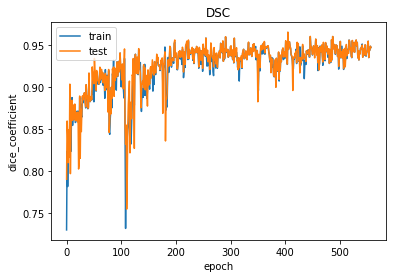

In [ ]:
file = pd.read_csv(checkpoint_filepath+'/model_history_log.csv')
plt.plot(file['dice_coefficient'])
plt.plot(file['val_dice_coefficient'])
plt.title('DSC')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig1 = plt.gcf()
plt.show()
fig1.savefig(model_saves+'/fold'+str(k+1)+'dsc.png')
# Dice Loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# fig2 = plt.gcf()
# plt.show()
# fig2.savefig(model_saves+'/fold'+str(k+1)+'loss.png')

In [ ]:
print(history.history['lr'])

[5e-06, 5e-06, 5e-06, 5e-06, 5e-06, 5e-06, 5e-06, 5e-06, 5e-06, 5e-06, 2.5e-06, 2.5e-06, 2.5e-06, 2.5e-06, 1.25e-06, 1.25e-06]
